In [11]:
import torch
import torch.nn as nn
from models.deeplabv3 import DeepLabV3
from models.gan import Generator
from models.gan import Discriminator

from datasets.cityscapes import CityScapes
from torchvision import transforms as T
import torchvision.transforms.functional as F
#visualization 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:

def freeze(net):
    for p in net.parameters():
        p.requires_grad_(False) 

def unfreeze(net):
    for p in net.parameters():
        p.requires_grad_(True)
def attack(G:nn.Module,D:nn.Module,T:nn.Module,iden,lr = 1e-2, momentum=0.9, lamda=100, iter=1500,clip_range = 1)->torch.tensor:
    """_summary_

    Args:
        G (nn.Module): Generator
        D (nn.Module): Discriminator
        T (nn.Module): Source model-> segmentation network
        iden (tensor): segmentation result Tensor of (B H W) in 0~255 int
        lr (float, optional): learing rate update z. Defaults to 1e-2.
        momentum (float, optional): momentum. Defaults to 0.9.
        lamda (int, optional): hyper param for weight of iden loss, lamda*iden loss. Defaults to 100.
        iter (int, optio0nal): update z iteration. Defaults to 1500.
        clip_range (int, optional): clip z to [-range, range]. Defaults to 1.

    Returns:
        tensor(cuda): _description_
    """
    ce = nn.CrossEntropyLoss().cuda()
    
    b,h,w = iden.shape
    z = torch.randn(b,G.z_dim,h//8,w//8)
    v = z.clone()
    G.eval()
    D.eval()

    # inner loop:
    for i in range(iter):
        fake = G(z)
        label = D(fake)
        BNLoss = []
        out = T(fake)['out'] # Deeplabv3
        BNLoss = []
        if z.grad is not None:
            z.grad.data.zero_()
        
        prior_loss = - label.mean() # E( D (G(z)) )
        iden_loss = ce(out,iden) # B C H W <-> B H W
        total_loss = prior_loss + lamda * iden_loss
        total_loss.backward()

        # update z
        v_prev = v.clone()
        gradient = z.grad.data
        v = momentum * v - lr * gradient
        z = z + ( - momentum * v_prev + (1 + momentum) * v)
        z = torch.clamp(z.detach(), -clip_range, clip_range).float()
        z.requires_grad = True

        prior_Loss_val = prior_loss.item()
        iden_Loss_val = iden_loss.item()

    return z.detach()

# global BNLoss
#######
# Setting 
#######
device = torch.device("cuda:0")
output_dir = ''

#######
# load models
#######
# source model fix
s = DeepLabV3().cuda()
source_ckpt = r"F:\COMP90055\GMIDA\train-runs\2022-09-22_22-44-38\checkpoint\deeplabv3-30.pth"

s.load_state_dict(torch.load(source_ckpt))
s.train()
freeze(s)
# s-> target model 
t = DeepLabV3().cuda()
t.load_state_dict(torch.load(source_ckpt))
t.train()
# Generator
z_dim = 256
g = Generator(3,z_dim).cuda()
g = torch.nn.DataParallel(g)
# cudnn.benchmark = True
generator_ckpt = r"F:\COMP90055\GMIDA\gan_result\2022-09-27_13-09-04\models_kitti_gan\kitti_30_G.pth"
g.load_state_dict(torch.load(generator_ckpt))
# Domain estimation
d = Discriminator(3,z_dim).cuda()
d = torch.nn.DataParallel(d)
discriminator_ckpt = r"F:\COMP90055\GMIDA\gan_result\2022-09-27_13-09-04\models_kitti_gan\kitti_30_D.pth"
d.load_state_dict(torch.load(discriminator_ckpt))
d.eval()
# z = rand n || attack


ce = nn.CrossEntropyLoss(ignore_index=255).cuda()

######
# load datas: Target city scape
######
root_dir = "F:\COMP90055\GMIDA\datas\CityScapes"
dataloader = CityScapes(root_dir,batch_size=4,split='train',shuffle=True)
resize = T.Resize((256,512))
label_resize = T.Resize((256,512),interpolation=F.InterpolationMode.NEAREST) 



def get_BN(name):
    
    def hook(model, input, output):
        running_mean = model.running_mean
        running_var = model.running_var
        

        nch = input[0].detach().shape[1]
        mean = input[0].detach().mean([0, 2, 3])
        var = input[0].detach().permute(1, 0, 2, 3).contiguous().view([nch, -1]).var(1, unbiased=False)

        BNLoss.append(torch.norm(running_var.data - var, 2) + torch.norm(
            running_mean.data - mean, 2))

    return hook

for m in s.backbone.modules():
    if isinstance(m, nn.BatchNorm2d):
        # print(m)
        m.register_forward_hook(get_BN(m))


d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


2.2908315658569336
3.312497854232788


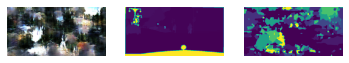

2.290148973464966
0.48448389768600464


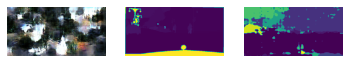

2.2905259132385254
0.2985757291316986


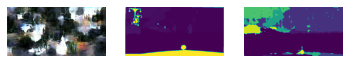

2.290681838989258
0.24991096556186676


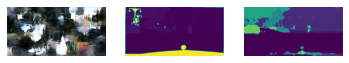

KeyboardInterrupt: 

In [15]:

for index,image,label in tqdm(dataloader):
    # print(label.size())
    label = label_resize(label).cuda()
    # z = attack(g,d,s,label)
    # G
    b,h,w = label.size()
    # print(label.size())
    ######### random z ##########
    # z = torch.randn(b,z_dim,h//8,w//8)

    ########## attack ###########

    z = torch.randn(b,z_dim,h//8,w//8).cuda().float()
    z.requires_grad = True
    v = z.clone()
    _lr = 1e-2
    _momentum=0.9
    _lamda=100
    _iter=1500
    _clip_range = 1
    # inner loop:
    for i in tqdm(range(_iter)):
        fake = g(z)
        pseudo_label = d(fake)
        BNLoss = []
        out = t(fake)['out'] # Deeplabv3
        BNLoss = []
        if z.grad is not None:
            z.grad.data.zero_()
        
        prior_loss = - pseudo_label.mean() # E( D (G(z)) )
        iden_loss = ce(out,label) # B C H W <-> B H W
        total_loss = prior_loss + _lamda * iden_loss
        total_loss.backward()

        # update z
        v_prev = v.clone() # previous v
        gradient = z.grad.data
        v = _momentum * v - _lr * gradient
        z = z + ( - _momentum * v_prev + (1 + _momentum) * v)
        z = torch.clamp(z.detach(), - _clip_range, _clip_range).float()
        z.requires_grad = True

        prior_Loss_val = prior_loss.item()
        iden_Loss_val = iden_loss.item()
        if i % 100 == 0:
            print(prior_Loss_val)
            print(iden_Loss_val)

            fig=plt.figure()
            
            fig.add_subplot(1,3,1)
            plt.axis('off')
            plt.imshow((fake[0].permute(1,2,0).detach().cpu().numpy()+1)/2)
            
            fig.add_subplot(1,3,2)
            plt.axis('off')
            plt.imshow(label[0].detach().cpu().numpy())
            
            fig.add_subplot(1,3,3)
            plt.axis('off')
            plt.imshow(out[0].data.max(0)[1].cpu().numpy())
            plt.show()
            
    ########### DA stage #########
    fake = g(z) # 
    BNLoss = []
    S_f = s(fake) # Use for MAE
    #             # hook BN for BNS ,back ward G
    print(BNLoss)
    # S_t = T(fake) # Use for MAE 
    # G.train()
    break
    # real = T(real)  # TAR loss use prob map calculate Square Max

